# Robust Linear Models

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Estimation

Load data:

In [3]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(
    hub_results.summary(
        yname="y", xname=["var_%d" % i for i in range(len(hub_results.params))]
    )
)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.791899
AIRFLOW      0.111005
WATERTEMP    0.302930
ACIDCONC     0.128650
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 18 Sep 2025                                         
Time:                        16:08:30                                         
No. Iterations:                    19                                         


Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.089504
AIRFLOW      0.119460
WATERTEMP    0.322355
ACIDCONC     0.117963
dtype: float64


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print("Parameters: ", andrew_results.params)

Parameters:  const       -40.881796
AIRFLOW       0.792761
WATERTEMP     1.048576
ACIDCONC     -0.133609
dtype: float64


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1 - 5) ** 2))
X = sm.add_constant(X)
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [8]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 5.06983879  0.52023238 -0.01289162]
[0.44279565 0.06836167 0.00604895]
[ 4.74754817  5.01035908  5.26887458  5.52309466  5.77301932  6.01864856
  6.25998238  6.49702079  6.72976377  6.95821134  7.18236349  7.40222022
  7.61778153  7.82904743  8.0360179   8.23869296  8.4370726   8.63115681
  8.82094562  9.006439    9.18763696  9.36453951  9.53714663  9.70545834
  9.86947463 10.0291955  10.18462096 10.33575099 10.48258561 10.6251248
 10.76336858 10.89731694 11.02696988 11.15232741 11.27338951 11.3901562
 11.50262747 11.61080332 11.71468375 11.81426876 11.90955835 12.00055253
 12.08725128 12.16965462 12.24776254 12.32157504 12.39109212 12.45631379
 12.51724003 12.57387086]


Estimate RLM:

In [9]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 5.00813481e+00  5.04697123e-01 -2.52276822e-03]
[0.14243616 0.02199022 0.0019458 ]


Draw a plot to compare OLS estimates to the robust estimates:

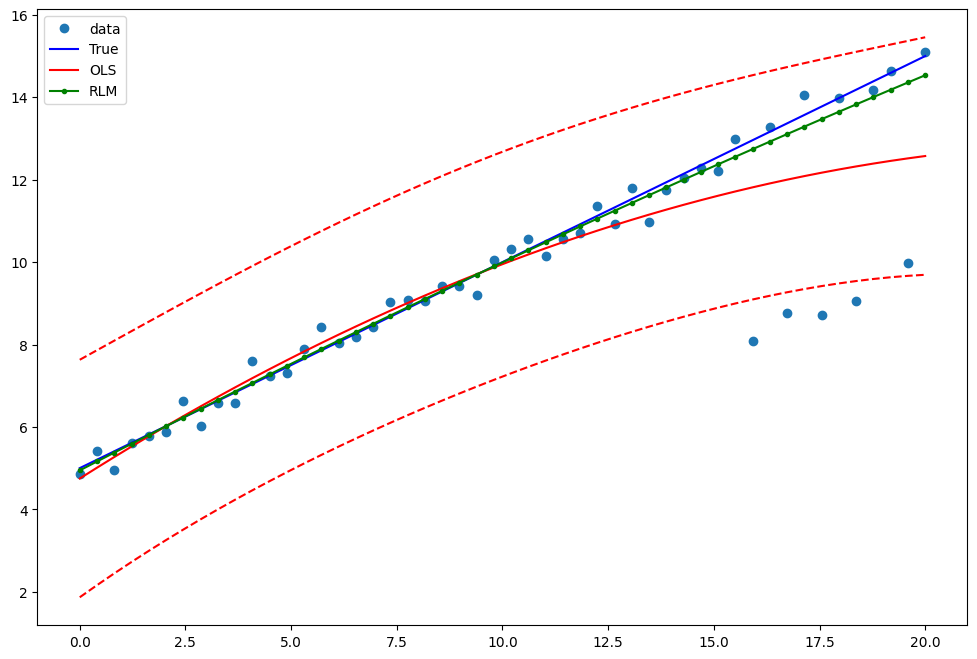

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

ax.plot(x1, res.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [11]:
X2 = X[:, [0, 1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.58945019 0.39131613]
[0.38302318 0.03300283]


Estimate RLM:

In [12]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.08574119 0.48321944]
[0.11129882 0.00958996]


Draw a plot to compare OLS estimates to the robust estimates:

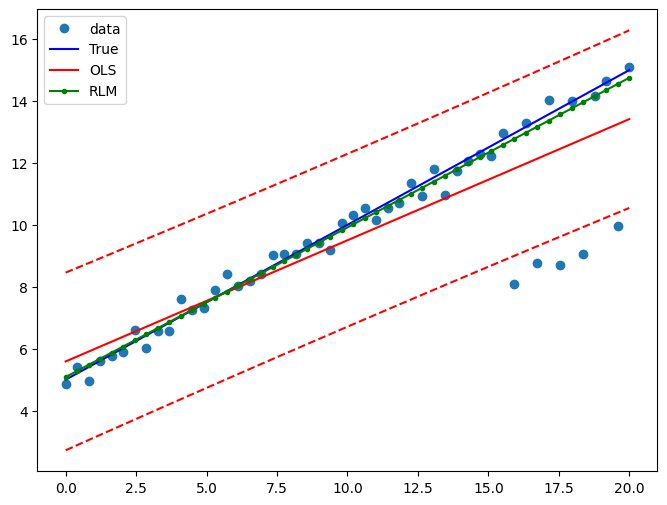

In [13]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
ax.plot(x1, res2.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm2.fittedvalues, "g.-", label="RLM")
legend = ax.legend(loc="best")